In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import layers

import datetime
import tensorflow_addons as tfa 
import pandas as pd
import matplotlib.pylab as plt
import numpy as np

/opt/anaconda3/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


## Load data

In [2]:
import read_rijksdata
NUM = 10000 # NUMBER OF IMAGES TO USE
MIN_ARTWORK_NUM = 10

In [5]:
img_folder = '/Users/erebor/Downloads/out_img'

In [6]:
X_train, Y_train, label_train, X_val, Y_val, label_val = read_rijksdata.load_data(img_folder=img_folder,
                                                                                  labels_file='labels.txt', 
                                                                                  names_file='names.txt')

In [7]:
if NUM:
    X = X_train[:NUM,:,:,:]
    Y = Y_train[:NUM]
else:
    X = X_train
    Y = Y_train


In [8]:
names = pd.read_csv('names.txt',delimiter = '/t',header=None,engine='python')
counts = pd.DataFrame(Y).value_counts()
min_counts = counts[counts>=MIN_ARTWORK_NUM]
min_idx = [index[0] for index in min_counts.index.tolist()]

min_mask_idx = []
for i, Y_ in enumerate(Y):
    if np.isin(Y_,min_idx):
        min_mask_idx.append(i)

In [9]:
X_ = X[min_mask_idx,:,:,:]
Y_ = Y[min_mask_idx]

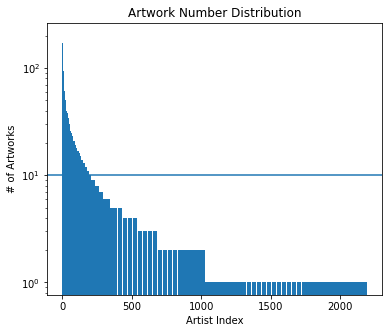

In [10]:

plt.figure(figsize=(6,5))
plt.bar(x=list(range(len(counts))),height=list(counts),align='center',width=0.9)
plt.xlabel('Artist Index')
plt.ylabel('# of Artworks')
plt.title('Artwork Number Distribution')

plt.yscale('log')
plt.axhline(10)
plt.show()

In [15]:
classes = len(list(set(Y_)))
print('# of classes:',classes)

counts = pd.DataFrame(Y_).value_counts()
print('Min # of artworks for all artists:',min(counts))
print('Min # of artworks specified:',MIN_ARTWORK_NUM)

print('X shape:',X_.shape)
print('Y shape:',Y_.shape)


# of classes: 207
Min # of artworks for all artists: 10
Min # of artworks specified: 10
X shape: (5843, 56, 56, 3)
Y shape: (5843,)


In [17]:
classes = len(list(set(Y_)))
Y_hot = tf.one_hot(indices=Y_,depth=classes)
#Y_val = tf.one_hot(indices=Y_val,depth=classes)

## Download and compile model

In [34]:
input_shape = (56,56,3)
enet_kwargs = {'include_top':False,
               'weights':'imagenet',
               'input_tensor':None,
               'input_shape':input_shape,
               'pooling':None,
               'classes':1,
               'classifier_activation':'softmax'}
enet_base = tf.keras.applications.efficientnet.EfficientNetB0(**enet_kwargs)
#enet_base.trainable = False

In [35]:
enet = tf.keras.models.Sequential()
enet.add(enet_base)
enet.add(tf.keras.layers.GlobalMaxPooling2D())
enet.add(tf.keras.layers.Dropout(rate=0.01))
enet.add(tf.keras.layers.Dense(classes, activation="softmax"))

In [36]:
enet.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 2, 2, 1280)        4049571   
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 207)               265167    
Total params: 4,314,738
Trainable params: 4,272,715
Non-trainable params: 42,023
_________________________________________________________________


In [37]:
# loss function
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False,label_smoothing=0.0,name='categorical_crossentropy')

# metrics

TopKs = []
for k in [1,5]:
    TopK = tf.keras.metrics.TopKCategoricalAccuracy(k=k, name='top_{}'.format(k))
    TopKs.append(TopK)
metrics = ["acc"]
metrics.extend(TopKs)

f1 = tfa.metrics.F1Score(num_classes=classes, threshold=0.05)
metrics.append(f1)

# Optimizer
# very average Adam settings
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# compile it all
enet.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics)

## Train model

In [38]:
print(X_.shape, type(X))
print(Y_hot.shape, type(Y_hot))

(5843, 56, 56, 3) <class 'numpy.ndarray'>
(5843, 207) <class 'tensorflow.python.framework.ops.EagerTensor'>


In [39]:
history = enet.fit(x=X_,y=Y_hot,validation_split=.20, epochs=5)

Epoch 1/5
147/147 [==============================] - 37s 217ms/step - loss: 0.0907 - acc: 0.0017 - top_1: 0.0017 - top_5: 0.0054 - f1_score: 1.3771e-04 - val_loss: 0.1087 - val_acc: 0.0000e+00 - val_top_1: 0.0000e+00 - val_top_5: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/5
147/147 [==============================] - 28s 193ms/step - loss: 0.0658 - acc: 0.0064 - top_1: 0.0064 - top_5: 0.0113 - f1_score: 1.3724e-04 - val_loss: 0.1013 - val_acc: 0.0000e+00 - val_top_1: 0.0000e+00 - val_top_5: 0.0026 - val_f1_score: 0.0000e+00
Epoch 3/5
147/147 [==============================] - 29s 200ms/step - loss: 0.0719 - acc: 0.0059 - top_1: 0.0059 - top_5: 0.0145 - f1_score: 2.0052e-04 - val_loss: 0.0989 - val_acc: 0.0026 - val_top_1: 0.0026 - val_top_5: 0.0068 - val_f1_score: 0.0000e+00
Epoch 4/5
147/147 [==============================] - 29s 194ms/step - loss: 0.0642 - acc: 0.0035 - top_1: 0.0035 - top_5: 0.0166 - f1_score: 1.7637e-04 - val_loss: 0.1020 - val_acc: 0.0026 - val_top_1: 0.0026 - v

In [40]:
# Save the weights
checkpoint_time = '{date:%Y-%m-%d_%H-%M}'.format(date=datetime.datetime.now())

save_file = './checkpoints/enet_{}'.format(checkpoint_time)
print('Saving to:',save_file)
enet.save_weights(save_file)

Saving to: ./checkpoints/enet_2022-04-28_18-01


In [44]:
enet.save('models/enet.h5')

## Re-load model and evaluation

In [45]:
reconstructed_model = keras.models.load_model('models/enet.h5')


In [47]:
allgood = np.testing.assert_allclose(enet.predict(X_), reconstructed_model.predict(X_))

In [49]:
print(allgood)

None


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

confusion_matrix = sklearn.metrics.confusion_matrix(y_true=Y, y_pred=y_pred, labels=None)

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(classes):
    fpr[i], tpr[i], _ = roc_curve(Y_train, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])